## Notebook to create a regional baseline model using an LSTM network

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. 
The code's logic is heavily based on Bischof et al (2024), [Hy2DL](https://github.com/KIT-HYD/Hy2DL) and [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1].

**Inverse Model**

We create a inverse model for the backward problem making use of mixture density networks. The model uses the [Caravan GRDC extension](10.5281/zenodo.10074416). This notebook attempts to use multiple GPUs.

**Authors**

Ashish Manoj J (ashish.manoj@kit.edu)

In [1]:
#Import necessary packages
import sys
import os
import pandas as pd
import numpy as np
import time 
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from typing import Optional
import torch.nn.functional as F

from typing import List, Dict
from itertools import groupby

sys.path.append("../aux_functions") # Here give the location of the aux_functions folder
from functions_datasets import CARAVAN as DataBase # define what you import as DataBase! Also ensure that all the required Caravan datasets are downloaded and stored in a single folder!
from functions_datasets import validate_samples 
from functions_training import nse_basin_averaged
from functions_evaluation import rmse, nse
from functions_aux import create_folder, set_random_seed, write_report

Part 1. Initialize information

In [2]:
# paths to access the information
path_entities = '../data/basins_grdc_germany.txt'
path_data = '/pfs/data5/home/kit/iwu/as2023/dataset/01_europe_flood/Caravan/' # Caution! using absolute path here as I do not want to save the data together with the code

# dynamic forcings and target
dynamic_input = ['total_precipitation_sum', 'temperature_2m_mean', 'volumetric_soil_water_layer_2_mean'] 
target = ['streamflow']

# static attributes that will be used
static_input = ['area', 'p_mean','ele_mt_sav','frac_snow']

# time periods
training_period = ['1980-06-01','2005-12-31']
validation_period = ['2000-01-01','2005-12-31']

model_hyper_parameters = {
    "input_size": len(dynamic_input) + len(static_input),
    "hidden_size1": 64,  # Number of hidden units for the first LSTM layer
    "hidden_size2": 32,  # Number of hidden units for the second LSTM layer
    "seq_length": 365,
    "batch_size": 256,
    "no_of_epochs": 10,
    "drop_out": 0.3,
    "learning_rate": 0.0001,
    "adapt_learning_rate_epoch": 1,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate": 3
}


# define random seed
seed = 143
# Name of the folder where the results will be stored 
path_save_folder = '../results/forward_germany_mdn'

# colorblind friendly palette for plotting
color_palette = {'observed': '#1f78b4','LSTM': '#ff7f00'}

In [3]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 4


In [4]:
# Create folder to store the results
create_folder(folder_path=path_save_folder)

Folder '../results/forward_germany_mdn' already exists.


Part 2. Class to create the dataset object used to manage the information

In [5]:
class BaseDataset(Dataset):
    """Base data set class to load and preprocess data.

    Parameters
    ----------
    dynamic_inputs : List[str]
        name of variables used as dynamic series input in the lstm
    static_inputs : List[str]
        static inputs used as input in the lstm (e.g. catchment attributes)
    target: List[str]
        target variable(s)
    sequence_length: int
        sequence length used in the LSTM
    time_period: List[str]
        initial and final date (e.g. ['1987-10-01','1999-09-30']) of the time period of interest #
    path_entities: str
        path to a txt file that contain the id of the entities (e.g. catchment`s ids) that will be analyzed
    path_data: str
        path to the folder were the data is stored
    path_addional features: str
        Optional parameter. Allows the option to add any arbitrary data that is not included in the standard data sets.
        Path to a pickle file (or list of paths for multiple files), containing a dictionary with each key corresponding 
        to one basin id and the value is a date-time indexed pandas DataFrame.      
    forcing: List[str]
        For CAMELS-US dataset we should specificy which forcing data will be used (e.g. daymet, maurer, ndlas, etc.)
    check_Nan: bool
        Boolean that indicate if one should check of NaN values while processing the data
    """

    #Function to initialize the data
    def __init__(self, 
                 dynamic_input: List[str],
                 static_input: List[str],
                 target: List[str], 
                 sequence_length: int,
                 time_period: List[str],
                 path_entities: str,
                 path_data: str,
                 path_additional_features: str = '',
                 forcings: List[str] = None,
                 check_NaN:bool = True
                 ):

        # read and create variables
        self.time_period = time_period # time period that is being considered
        self.dynamic_input= dynamic_input  # dynamic forcings going as inputs of in the lstm
        self.target = target  # target variable
        self.sequence_length = sequence_length # sequence length

        entities_ids = np.loadtxt(path_entities, dtype='str').tolist() 
        # save the cathments as a list even if there is just one
        self.entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids # catchments

        self.sequence_data = {} # store information that will be used to run the lstm
        self.df_ts = {} # store processed dataframes for all basins
        self.scaler = {} # information to standardize the data 
        self.basin_std = {} # std of the target variable of each basin (can be used later in the loss function)
        self.valid_entities= [] # list of the elements that meet the criteria to be used by the lstm

        # process the attributes
        self.static_input = static_input # static attributes going as inputs to the lstm
        if static_input:
            self.df_attributes = self._load_attributes(path_data)

        # process additional features that will be included in the inputs (optional) ---
        if path_additional_features:
            self.additional_features = self._load_additional_features(path_additional_features)
        
        # This loop goes through all the catchments. For each catchment in creates an entry in the dictionary
        # self.sequence_data, where we will store the information that will be sent to the lstm
        for id in self.entities_ids:
            # load time series for specific catchment id
            df_ts = self._load_data(path_data=path_data, catch_id=id)
            # add additional features (optional)
            if path_additional_features:
                df_ts = pd.concat([df_ts, self.additional_features[id]], axis=1)
            
            # Defines the start date considering the offset due to sequence length. We want that, if possible, the start
            # date is the first date of prediction.
            start_date = pd.to_datetime(self.time_period[0],format="%Y-%m-%d")
            end_date = pd.to_datetime(self.time_period[1],format="%Y-%m-%d")
            freq = pd.infer_freq(df_ts.index)
            warmup_start_date = start_date - (self.sequence_length-1)*pd.tseries.frequencies.to_offset(freq)
            # filter dataframe for the period and variables of interest
            df_ts = df_ts.loc[warmup_start_date:end_date, self.dynamic_input + self.target]
            
            # reindex the dataframe to assure continuos data between the start and end date of the time period. Missing 
            # data will be filled with NaN, so this will be taken care of later. 
            full_range = pd.date_range(start=warmup_start_date, end=end_date, freq=freq)
            df_ts = df_ts.reindex(full_range)
            
            # checks for invalid samples due to NaN or insufficient sequence length
            flag = validate_samples(x = df_ts.loc[:, self.dynamic_input].values, 
                                    y = df_ts.loc[:, self.target].values, 
                                    attributes = self.df_attributes.loc[id].values if static_input else None, 
                                    seq_length = self.sequence_length,
                                    check_NaN = check_NaN
                                    )
            
            # create a list that contain the indexes (basin, day) of the valid samples
            valid_samples = np.argwhere(flag == 1)
            self.valid_entities.extend([(id, int(f[0])) for f in valid_samples])
            
            # only store data if this basin has at least one valid sample in the given period
            if valid_samples.size>0:
                self.df_ts[id] = df_ts
                
                # create dictionary entry for the basin
                self.sequence_data[id] = {}

                # store the information of the basin in a nested dictionary
                self.sequence_data[id]['x_d'] = torch.tensor(df_ts.loc[:, self.dynamic_input].values, dtype=torch.float32)
                self.sequence_data[id]['y'] = torch.tensor(df_ts.loc[:, self.target].values, dtype=torch.float32)
                if self.static_input:
                    self.sequence_data[id]['x_s'] = torch.tensor(self.df_attributes.loc[id].values, dtype=torch.float32)
                    
    def __len__(self):
        return len(self.valid_entities)
    
    def __getitem__(self, id):
        """This function is used by PyTorch's dataloader to extract the information"""
        basin, i = self.valid_entities[id]

        # tensor of inputs
        x_LSTM = self.sequence_data[basin]['x_d'][i-self.sequence_length+1:i+1, :]
        if self.static_input:
            x_s = self.sequence_data[basin]['x_s'].repeat(x_LSTM.shape[0],1)
            x_LSTM = torch.cat([x_LSTM, x_s], dim=1)
        
        # Ttensor of outputs
        y_obs = self.sequence_data[basin]['y'][i]

        # optional also return the basin_std
        if self.basin_std:
            return x_LSTM, y_obs, self.basin_std[basin].unsqueeze(0)
        else:
            return x_LSTM, y_obs

    def _load_attributes(self, path_data: str) -> pd.DataFrame:
        """Call the specific function that reads the static attributes information.
        
        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored
            
        Returns
        -------
        df_attributes: pd.DataFrame
            Dataframe containing the attributes of interest for the catchments of interest
        """
        df_attributes = DataBase.read_attributes(path_data=path_data)
        df_attributes = df_attributes.loc[self.entities_ids, self.static_input]
        return df_attributes

    def _load_data(self, path_data: str, catch_id:str) -> pd.DataFrame:
        """Call the specific function that reads a specific catchment timeseries into a dataframe.

        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored.
        catch_id : str
            basin_id.
        forcings : str
            Can be e.g. 'daymet' or 'nldas', etc. Must match the folder names in the 'basin_mean_forcing' directory. 

        Returns
        -------
        df: pd.DataFrame
            Dataframe with the catchments` timeseries
        """
        df_ts = DataBase.read_data(path_data=path_data, catch_id=catch_id)
        return df_ts

    def _load_additional_features(self, path_additional_features: str) -> Dict[str, pd.DataFrame]:
        """Read pickle dictionary containing additional features.

        Parameters
        ----------
        path_additional_features : str
            Path to a pickle file (or list of paths for multiple files), containing a dictionary with each key 
            corresponding to one basin id and the value is a date-time indexed pandas DataFrame.   

        Returns
        -------
        additional_features: Dict[str, pd.DataFrame]
            Dictionary where each key is a basin and each value is a date-time indexed pandas DataFrame with the 
            additional features
        """
        
        with open(path_additional_features, "rb") as file:
            additional_features = pickle.load(file)
        return additional_features
  
    def calculate_basin_std(self):
        """Fill the self.basin_std dictionary with the standard deviation of the target variables for each basin"""
        for id, data in self.sequence_data.items():
            self.basin_std[id] = torch.tensor(np.nanstd(data['y'].numpy()), dtype=torch.float32)
    
    def calculate_global_statistics(self,path_save_scaler:Optional[str] = ''):
        """Fill the self.scalar dictionary 
        
        The function calculates the global mean and standard deviation of the dynamic inputs, target variables and 
        static attributes, and store the in a dictionary. It will be used later to standardize used in the LSTM. This
        function should be called only in training period. 
        """
        global_x = np.vstack([df.loc[:, self.dynamic_input].values for df in self.df_ts.values()])
        self.scaler['x_d_mean'] = torch.tensor(np.nanmean(global_x, axis=0), dtype=torch.float32)
        self.scaler['x_d_std'] = torch.tensor(np.nanstd(global_x, axis=0), dtype=torch.float32)
        del global_x

        global_y = np.vstack([df.loc[:, self.target].values for df in self.df_ts.values()])
        self.scaler['y_mean'] = torch.tensor(np.nanmean(global_y, axis=0), dtype=torch.float32)
        self.scaler['y_std'] = torch.tensor(np.nanstd(global_y, axis=0), dtype=torch.float32)
        del global_y

        if self.static_input:
            self.scaler['x_s_mean'] = torch.tensor(self.df_attributes.mean().values, dtype= torch.float32)
            self.scaler['x_s_std'] = torch.tensor(self.df_attributes.std().values, dtype= torch.float32)

        if path_save_scaler: #save the results in a pickle file
            with open(path_save_scaler+'/scaler.pickle', 'wb') as f:
                pickle.dump(self.scaler, f)

    
    def standardize_data(self, standardize_output:bool=True):
        """Standardize the data used in the LSTM. 

        The function standardize the data contained in the self.sequence_data dictionary 
        
        Parameters
        ----------
        standardize_output : bool
            Boolean to define if the output should be standardize or not. 
        """
        for basin in self.sequence_data.values():
            # Standardize input
            basin['x_d'] = (basin['x_d'] - self.scaler['x_d_mean']) / self.scaler['x_d_std']
            if self.static_input:
                basin['x_s'] = (basin['x_s'] - self.scaler['x_s_mean']) / self.scaler['x_s_std']
            # Standardize output
            if standardize_output:
                basin['y'] = (basin['y'] - self.scaler['y_mean']) / self.scaler['y_std']

Part 3. Create the different datasets

In [6]:
# Dataset training
training_dataset = BaseDataset(dynamic_input=dynamic_input,
                               static_input=static_input,
                               target=target,
                               sequence_length=model_hyper_parameters['seq_length'],
                               time_period=training_period,
                               path_entities=path_entities,
                               path_data=path_data,
                               check_NaN=True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder) # the global statistics are calculated in the training period!
training_dataset.standardize_data()

ValueError: No objects to concatenate

In [7]:
path_data

'/pfs/data5/home/kit/iwu/as2023/dataset/01_europe_flood/Caravan/'

In [8]:
# Dataset validation
validation_dataset = BaseDataset(dynamic_input=dynamic_input,
                                 static_input=static_input,
                                 target=target,
                                 sequence_length=model_hyper_parameters['seq_length'],
                                 time_period=validation_period,
                                 path_entities=path_entities,
                                 path_data=path_data,
                                 check_NaN=True) # Changed to True to avoid NaN error in this version of code. Not necessary in original

validation_dataset.scaler = training_dataset.scaler # read the global statisctics calculated in the training period
validation_dataset.standardize_data(standardize_output=False)

Part 4. Create the different dataloaders

In [9]:
# DataLoader for training data.
train_loader = DataLoader(training_dataset, 
                          batch_size=model_hyper_parameters['batch_size'],
                          shuffle=True,
                          drop_last = True)

print('Batches in training: ', len(train_loader))
x_lstm, y, per_basin_target_std = next(iter(train_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape} | per_basin_target_std: {per_basin_target_std.shape}')

Batches in training:  11730
x_lstm: torch.Size([256, 365, 7]) | y: torch.Size([256, 1]) | per_basin_target_std: torch.Size([256, 1])


In [10]:
# DataLoader for validation data.
validation_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(validation_dataset.valid_entities), 
                                                                           lambda x: x[1][0])] # each basin is one batch

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_sampler=validation_batches)

# see if the batches are loaded correctly
print('Batches in validation: ', len(validation_loader))
x_lstm, y= next(iter(validation_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins = [next(group)[0] for key, group in groupby(validation_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin = [[id for _, id in group] for key, group in groupby(validation_dataset.valid_entities, 
                                                                            key=lambda x: x[0])]

Batches in validation:  326
x_lstm: torch.Size([2192, 365, 7]) | y: torch.Size([2192, 1])


Part 5. Define LSTM class

In [12]:
# Define device (this will use all available GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Cuda_MDN_LSTM(nn.Module):
    def __init__(self, model_hyper_parameters, num_mixtures=3):
        super().__init__()
        self.num_features = model_hyper_parameters['input_size']
        self.hidden_units1 = model_hyper_parameters['hidden_size1']
        self.hidden_units2 = model_hyper_parameters['hidden_size2']
        self.num_mixtures = num_mixtures

        # Two LSTM layers with different hidden units
        self.lstm1 = nn.LSTM(input_size=self.num_features, hidden_size=self.hidden_units1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=self.hidden_units1, hidden_size=self.hidden_units2, batch_first=True)

        self.dropout = nn.Dropout(model_hyper_parameters['drop_out'])
        
        self.linear_pi = nn.Linear(in_features=self.hidden_units2, out_features=num_mixtures)
        self.linear_mu = nn.Linear(in_features=self.hidden_units2, out_features=num_mixtures)
        self.linear_sigma = nn.Linear(in_features=self.hidden_units2, out_features=num_mixtures)
           
    def forward(self, x):
        
        # Check for NaNs in input and print if any
        if torch.isnan(x).any() or torch.isinf(x).any():
            print("Input contains NaNs or Infs")
            print(x)
            assert False, "Input contains NaNs or Infs"
        
        # Initialize hidden state with zeros
        batch_size = x.shape[0]
        h0_1 = torch.zeros(1, batch_size, self.hidden_units1, 
                           requires_grad=True, dtype=torch.float32, device=x.device)
        c0_1 = torch.zeros(1, batch_size, self.hidden_units1, 
                           requires_grad=True, dtype=torch.float32, device=x.device)
        
        h0_2 = torch.zeros(1, batch_size, self.hidden_units2, 
                           requires_grad=True, dtype=torch.float32, device=x.device)
        c0_2 = torch.zeros(1, batch_size, self.hidden_units2, 
                           requires_grad=True, dtype=torch.float32, device=x.device)
        
        # First LSTM layer
        out, (h1, c1) = self.lstm1(x, (h0_1, c0_1))
        assert not torch.isnan(out).any(), "First LSTM output contains NaNs"

        # Second LSTM layer
        out, (h2, c2) = self.lstm2(out, (h0_2, c0_2))
        assert not torch.isnan(out).any(), "Second LSTM output contains NaNs"
    
        out = out[:, -1, :]  # Sequence to one
        out = self.dropout(out)
        assert not torch.isnan(out).any(), "After dropout, output contains NaNs"
    
        linear_pi_out = self.linear_pi(out)
        assert not torch.isnan(linear_pi_out).any(), "linear_pi output contains NaNs"
        assert not (linear_pi_out.abs() > 1e6).any(), "linear_pi output contains extreme values"
    
        log_pi = F.log_softmax(linear_pi_out, dim=-1)
        pi = torch.exp(log_pi)
        assert not torch.isnan(pi).any(), "pi contains NaNs"
    
        mu = self.linear_mu(out)
        assert not torch.isnan(mu).any(), "mu contains NaNs"
    
        sigma = torch.exp(self.linear_sigma(out))
        assert not torch.isnan(sigma).any(), "sigma contains NaNs"
    
        return pi, mu, sigma


def save_checkpoint(model, optimizer, scheduler, epoch, path):
    if not os.path.exists(path):
        os.makedirs(path)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    torch.save(checkpoint, os.path.join(path, 'checkpoint.pth'))
    print(f"Checkpoint saved at epoch {epoch + 1}")

def load_checkpoint(model, optimizer, scheduler, path):
    checkpoint = torch.load(os.path.join(path, 'checkpoint.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded: starting from epoch {start_epoch}")
    return start_epoch


In [13]:
# Potential loss functions
# 1. Neural hydrology (Gaussian)

oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians

def gaussian_distribution(y, mu, sigma):
    """
    Compute the Gaussian probability density function values for given y, mu, and sigma.
    
    Parameters:
    y (Tensor): Target values.
    mu (Tensor): Means of the Gaussian components.
    sigma (Tensor): Standard deviations of the Gaussian components.
    
    Returns:
    Tensor: The probability density values for the Gaussian distribution.
    """

    # Expand y to have the same size as mu, substract mu, and divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)

    # Compute the exponent term of the Gaussian distribution
    result = -0.5 * (result * result)

    # Aooky the Gaussian formula:  exp(-0.5 * ((y - mu) / sigma)^2) / (sigma * sqrt(2 * pi))
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, mu, sigma, y):
    """
    Compute the loss function for a Mixture Density Network (MDN).
    
    Parameters:
    pi (Tensor): Mixing coefficients for the Gaussian components.
    mu (Tensor): Means of the Gaussian components.
    sigma (Tensor): Standard deviations of the Gaussian components.
    y (Tensor): Target values.
    
    Returns:
    Tensor: The mean negative log-likelihood loss for the MDN.
    """
    # Check for NaNs in mu and sigma
    assert not torch.isnan(mu).any(), "mu contains NaNs"
    assert not torch.isnan(sigma).any(), "sigma contains NaNs"
    
    # Compute the Gaussian probability density function values
    result = gaussian_distribution(y, mu, sigma) * pi

    # Sum the weighted Gaussian densities across all components
    result = torch.sum(result, dim=1)

    # Compute the negative log-likelihood
    result = -torch.log(result + 1e-10)

    # Return the mean loss over all data points
    return torch.mean(result)

def mdn_loss(pi, mu, sigma, y): # Ashish - 19.06.2024
    # Check for NaNs in mu and sigma
    assert not torch.isnan(mu).any(), "mu contains NaNs"
    assert not torch.isnan(sigma).any(), "sigma contains NaNs"
    
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y.unsqueeze(-1))) * pi
    loss = torch.sum(loss, dim=1)
    loss = -torch.log(loss + 1e-10)
    return torch.mean(loss)

In [15]:
#run only if cuDNN version incompatibility in cluster
!pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Part 6 Train LSTM

In [16]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

# Construct the model
set_random_seed(seed=seed)
lstm_model = Cuda_MDN_LSTM(model_hyper_parameters).to(device)

# Wrap the model with DataParallel (if using multiple GPUs)
# lstm_model = nn.DataParallel(lstm_model)

# Optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=model_hyper_parameters["learning_rate"])

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=model_hyper_parameters["adapt_learning_rate_epoch"], gamma=model_hyper_parameters["adapt_gamma_learning_rate"])

# Set forget gate bias to ensure that the model is capable of learning long-term dependencies
hidden_size1 = model_hyper_parameters['hidden_size1']
hidden_size2 = model_hyper_parameters['hidden_size2']
forget_gate_bias_value = model_hyper_parameters["set_forget_gate"]

# Accessing and setting forget gate bias for the first LSTM layer
lstm_model.lstm1.bias_hh_l0.data[hidden_size1:2 * hidden_size1] = forget_gate_bias_value
# Accessing and setting forget gate bias for the second LSTM layer
lstm_model.lstm2.bias_hh_l0.data[hidden_size2:2 * hidden_size2] = forget_gate_bias_value

print("Forget gate biases set successfully.")

checkpoint_path = path_save_folder
start_epoch = 0
if os.path.exists(os.path.join(checkpoint_path, 'checkpoint.pth')):
    start_epoch = load_checkpoint(lstm_model, optimizer, scheduler, checkpoint_path)

training_time = time.time()
# Loop through the different epochs
for epoch in range(start_epoch, model_hyper_parameters["no_of_epochs"]):
    
    epoch_start_time = time.time()
    total_loss = 0
    # Training ----------------------------------------------------------------------
    lstm_model.train()
    for (x_lstm, y, per_basin_target_std) in train_loader: 
        optimizer.zero_grad() # sets gradients of weights and bias to zero

        # Move data to the device
        x_lstm = x_lstm.to(device).float()
        y = y.to(device).float()
        
        # Check for NaNs in the batch
        if torch.isnan(x_lstm).any() or torch.isnan(y).any() or torch.isinf(x_lstm).any() or torch.isinf(y).any():
            print("Batch input or target contains NaNs or Infs")
            print(batch_x)
            print(batch_y)
            assert False, "Batch input or target contains NaNs or Infs"
            
        # Perform forward pass of the input through the model
        pi, mu, sigma = lstm_model(x_lstm)

        # Calculate the loss function based on the predicted parameters
        loss = mdn_loss_fn(pi, mu, sigma, y)

        # Check loss value
        assert not torch.isnan(loss).any(), "Loss contains NaNs"
        
        loss.backward() # backpropagates
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        
        optimizer.step() # update weights
        total_loss += loss.item()
        
        # remove from cuda
        del x_lstm, y, pi, mu, sigma, per_basin_target_std
        torch.cuda.empty_cache()
        
    # average loss training   
    average_loss_training = total_loss / len(train_loader)
    
    # Validation ----------------------------------------------------------------------
    lstm_model.eval()
    validation_results = {}
    with torch.no_grad():
        for i, (x_lstm, y) in enumerate(validation_loader): 
            # Run LSTM
            pi, mu, sigma = lstm_model(x_lstm.to(device).float())

            # Sample from the mixture of Gaussian distributions
            y_sim = torch.sum(pi * mu, dim=-1)

            # scale back prediction
            y_sim = y_sim * validation_dataset.scaler['y_std'].to(device) + validation_dataset.scaler['y_mean'].to(device)

            # Calculate standard deviation and scale it back
            std_sim = torch.sqrt(torch.sum(pi * (sigma ** 2 + mu ** 2) - (pi * mu) ** 2, dim=-1))
            std_sim = std_sim * validation_dataset.scaler['y_std'].to(device) 

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df_ts = validation_dataset.df_ts[valid_basins[i]].iloc[valid_entity_per_basin[i]]
            # df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
            #                         'y_sim': y_sim.flatten().cpu().detach().numpy(),
            #                         'st_dev': std_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
            df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index) # Since for NSE validation we want single values
            df_ts = pd.concat([df_ts, df_new], axis=1)
            df_ts = df_ts.filter(['y_obs', 'y_sim'])
            validation_results[valid_basins[i]] = df_ts
            
            # remove from cuda
            del x_lstm, y, y_sim, pi, mu, sigma, std_sim
            torch.cuda.empty_cache()       
            
        # average loss validation
        loss_validation = nse(df_results=validation_results)

    # save model and optimizer state after every epoch
    save_checkpoint(lstm_model, optimizer, scheduler, epoch, checkpoint_path)
    path_saved_model = path_save_folder+'/epoch_' + str(epoch+1)
    torch.save(lstm_model.state_dict(), path_saved_model)
            
    # print epoch report
    epoch_training_time = time.time() - epoch_start_time
    LR = optimizer.param_groups[0]['lr']
    report = f'Epoch: {epoch + 1:<2} | Loss training: {"%.3f " % (average_loss_training)} | NSE validation: {"%.3f " % (loss_validation)} | LR:{"%.5f " % (LR)} | Training time: {"%.1f " % (epoch_training_time)} s'
    print(report)
    # save epoch report in txt file
    write_report(file_path=path_save_folder + '/run_progress.txt', text=report)
    # modify learning rate
    scheduler.step()

# print total report
total_training_time = time.time() - training_time
report = f'Total training time: {"%.1f " % (total_training_time)} s'
print(report)
# save total report in txt file
write_report(file_path=path_save_folder + '/run_progress.txt', text=report)


Forget gate biases set successfully.
Checkpoint saved at epoch 1
Epoch: 1  | Loss training: -0.038  | NSE validation: 0.593  | LR:0.00010  | Training time: 280.5  s
Checkpoint saved at epoch 2
Epoch: 2  | Loss training: -0.265  | NSE validation: 0.629  | LR:0.00005  | Training time: 271.3  s
Checkpoint saved at epoch 3
Epoch: 3  | Loss training: -0.316  | NSE validation: 0.625  | LR:0.00003  | Training time: 270.7  s
Checkpoint saved at epoch 4
Epoch: 4  | Loss training: -0.337  | NSE validation: 0.634  | LR:0.00001  | Training time: 270.7  s
Checkpoint saved at epoch 5
Epoch: 5  | Loss training: -0.347  | NSE validation: 0.639  | LR:0.00001  | Training time: 270.2  s
Checkpoint saved at epoch 6
Epoch: 6  | Loss training: -0.352  | NSE validation: 0.643  | LR:0.00000  | Training time: 272.0  s
Checkpoint saved at epoch 7
Epoch: 7  | Loss training: -0.355  | NSE validation: 0.642  | LR:0.00000  | Training time: 274.5  s
Checkpoint saved at epoch 8
Epoch: 8  | Loss training: -0.356  | NS

In [17]:
lstm_model

Cuda_MDN_LSTM(
  (lstm1): LSTM(7, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear_pi): Linear(in_features=32, out_features=3, bias=True)
  (linear_mu): Linear(in_features=32, out_features=3, bias=True)
  (linear_sigma): Linear(in_features=32, out_features=3, bias=True)
)

Part 7. Test LSTM (All catchments, 2011-2020)

In [18]:
# Dataset testing
#path_entities = r"C:\Users\as2023\bwSyncShare\01_Analysis\03_Backward_Hydrology\01_Analysis\02_p_inverse\basins_grdc_trial.txt"
testing_period = ['2006-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=True)
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]

Batches in testing:  329
x_lstm: torch.Size([5479, 365, 7]) | y: torch.Size([5479, 1])


In [19]:
# Set the model to evaluation mode
lstm_model.eval()
test_results = {}

# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # Move input data to the appropriate device
        x_lstm = x_lstm.to(device).float()
        y = y.to(device).float()

        # Run LSTM model to get the mixture components
        pi, mu, sigma = lstm_model(x_lstm)

        # Weighted mean
        y_sim_weighted = torch.sum(pi * mu, dim=-1)

        # Get the index of the component with the highest weight for each sample
        max_pi_index = torch.argmax(pi, dim=-1)

        # Gather the means corresponding to the highest weights
        y_sim_most_probable = mu.gather(1, max_pi_index.unsqueeze(1)).squeeze(1)

        # Scale back predictions using test dataset's scaler
        y_sim_weighted = y_sim_weighted * test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)
        y_sim_most_probable = y_sim_most_probable * test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # Calculate standard deviation and scale it back
        std_sim = torch.sqrt(torch.sum(pi * (sigma ** 2 + mu ** 2) - (pi * mu) ** 2, dim=-1))
        std_sim = std_sim * test_dataset.scaler['y_std'].to(device)

        # Join results in a DataFrame and store them in a dictionary
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={
            'y_obs': y.flatten().cpu().detach().numpy(), 
            'y_sim_weighted': y_sim_weighted.flatten().cpu().detach().numpy(),
            'y_sim_most_probable': y_sim_most_probable.flatten().cpu().detach().numpy(),
            'st_dev': std_sim.flatten().cpu().detach().numpy()
        }, index=df_ts.index)

        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts[['y_obs', 'y_sim_weighted', 'y_sim_most_probable', 'st_dev']]
        test_results[valid_basins_testing[i]] = df_ts
        
        # Remove from CUDA to free memory
        del x_lstm, y, pi, mu, sigma, y_sim_weighted, y_sim_most_probable, std_sim
        torch.cuda.empty_cache()

Part 8. Initial analysis

In [20]:
# Simulated and observed results
y_sim_weighted = pd.concat([pd.DataFrame({key: value['y_sim_weighted']}) for key, value in test_results.items()], axis=1)
y_sim_most_probable = pd.concat([pd.DataFrame({key: value['y_sim_most_probable']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)
y_std = pd.concat([pd.DataFrame({key: value['st_dev']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim_weighted = y_sim_weighted.set_index(list(test_results.values())[0]['y_sim_weighted'].index)
y_sim_most_probable = y_sim_most_probable.set_index(list(test_results.values())[0]['y_sim_most_probable'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)
y_std = y_std.set_index(list(test_results.values())[0]['st_dev'].index)

# Export the results
y_sim_weighted.to_csv(path_save_folder+'/y_sim_weighted.csv', index=True, header=True)
y_sim_most_probable.to_csv(path_save_folder+'/y_sim_most_probable.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)
y_std.to_csv(path_save_folder+'/y_std.csv', index=True, header=True)

In [28]:
y_obs[basin_to_analyze]

2006-01-01    0.64
2006-01-02    0.91
2006-01-03    0.86
2006-01-04    0.74
2006-01-05    0.68
              ... 
2020-12-27     NaN
2020-12-28     NaN
2020-12-29     NaN
2020-12-30     NaN
2020-12-31     NaN
Freq: D, Name: GRDC_6342670, Length: 5479, dtype: float32

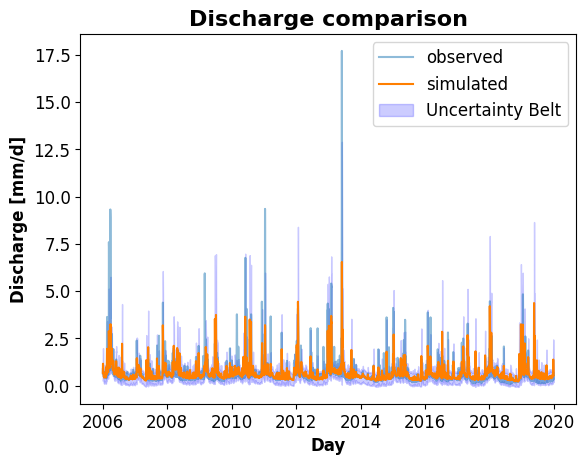

In [27]:
# Plot simulated and observed discharges
basin_to_analyze = 'GRDC_6342670'

# Calculate and plot uncertainty belt (mean ± st_dev)
mean_sim = test_results[basin_to_analyze]['y_sim_weighted']
std_sim = test_results[basin_to_analyze]['st_dev']

plt.plot(y_obs[basin_to_analyze], label="observed", color=color_palette["observed"], alpha=0.5)
plt.plot(y_sim_weighted[basin_to_analyze], label="simulated", color=color_palette["LSTM"])
plt.fill_between(mean_sim.index, mean_sim - std_sim, mean_sim + std_sim, color='blue', alpha=0.2, label="Uncertainty Belt")

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)

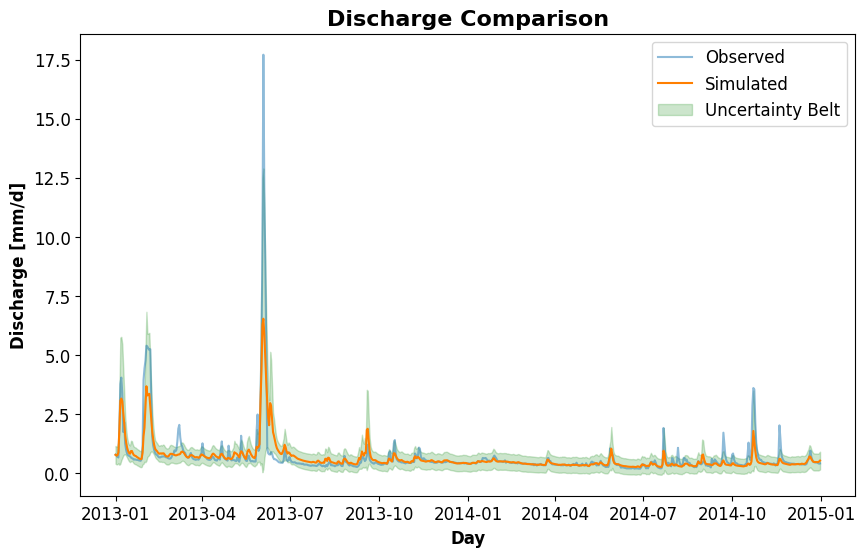

In [34]:
# Specify start and end dates
basin_to_analyze = 'GRDC_6342670'
start_date = '2013-01-01'  # Replace with your start date
end_date = '2014-12-31'    # Replace with your end date

# Convert date range to Pandas datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Subset the data
mean_sim = test_results[basin_to_analyze]['y_sim_weighted'].loc[start_date:end_date]
std_sim = test_results[basin_to_analyze]['st_dev'].loc[start_date:end_date]
observed = y_obs[basin_to_analyze].loc[start_date:end_date]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(observed, label="Observed", color=color_palette["observed"], alpha=0.5)
plt.plot(mean_sim, label="Simulated", color=color_palette["LSTM"])
plt.fill_between(mean_sim.index, mean_sim - std_sim, mean_sim + std_sim, color='green', alpha=0.2, label="Uncertainty Belt")

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge Comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right", fontsize=12)

# Display plot
plt.show()

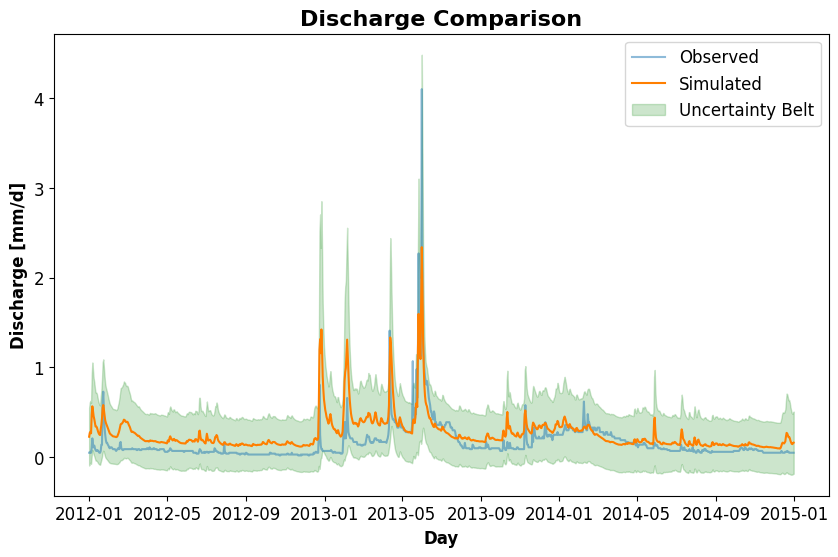

In [36]:
#camelsgb_8009
basin_to_analyze = 'GRDC_6340220'

start_date = '2012-01-01'  # Replace with your start date
end_date = '2014-12-31'    # Replace with your end date

# Convert date range to Pandas datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Subset the data
mean_sim = test_results[basin_to_analyze]['y_sim_weighted'].loc[start_date:end_date]
std_sim = test_results[basin_to_analyze]['st_dev'].loc[start_date:end_date]
observed = y_obs[basin_to_analyze].loc[start_date:end_date]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(observed, label="Observed", color=color_palette["observed"], alpha=0.5)
plt.plot(mean_sim, label="Simulated", color=color_palette["LSTM"])
plt.fill_between(mean_sim.index, mean_sim - std_sim, mean_sim + std_sim, color='green', alpha=0.2, label="Uncertainty Belt")

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge Comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right", fontsize=12)

# Display plot
plt.show()

Weiherbach and Schwarzbach

In [41]:
# Dataset testing
path_entities = '../data/basins_grdc_trial.txt'
testing_period = ['1980-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=True)
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]
# Set the model to evaluation mode
lstm_model.eval()
test_results = {}

# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # Move input data to the appropriate device
        x_lstm = x_lstm.to(device).float()
        y = y.to(device).float()

        # Run LSTM model to get the mixture components
        pi, mu, sigma = lstm_model(x_lstm)

        # Weighted mean
        y_sim_weighted = torch.sum(pi * mu, dim=-1)

        # Get the index of the component with the highest weight for each sample
        max_pi_index = torch.argmax(pi, dim=-1)

        # Gather the means corresponding to the highest weights
        y_sim_most_probable = mu.gather(1, max_pi_index.unsqueeze(1)).squeeze(1)

        # Scale back predictions using test dataset's scaler
        y_sim_weighted = y_sim_weighted * test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)
        y_sim_most_probable = y_sim_most_probable * test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # Calculate standard deviation and scale it back
        std_sim = torch.sqrt(torch.sum(pi * (sigma ** 2 + mu ** 2) - (pi * mu) ** 2, dim=-1))
        std_sim = std_sim * test_dataset.scaler['y_std'].to(device)

        # Join results in a DataFrame and store them in a dictionary
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={
            'y_obs': y.flatten().cpu().detach().numpy(), 
            'y_sim_weighted': y_sim_weighted.flatten().cpu().detach().numpy(),
            'y_sim_most_probable': y_sim_most_probable.flatten().cpu().detach().numpy(),
            'st_dev': std_sim.flatten().cpu().detach().numpy()
        }, index=df_ts.index)

        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts[['y_obs', 'y_sim_weighted', 'y_sim_most_probable', 'st_dev']]
        test_results[valid_basins_testing[i]] = df_ts
        
        # Remove from CUDA to free memory
        del x_lstm, y, pi, mu, sigma, y_sim_weighted, y_sim_most_probable, std_sim
        torch.cuda.empty_cache()

Batches in testing:  2
x_lstm: torch.Size([2193, 365, 7]) | y: torch.Size([2193, 1])


In [42]:
path_save_folder = '../results/inverse_europe_mdn_weiherbach'
create_folder(folder_path=path_save_folder)
# Simulated and observed results
y_sim_weighted = pd.concat([pd.DataFrame({key: value['y_sim_weighted']}) for key, value in test_results.items()], axis=1)
y_sim_most_probable = pd.concat([pd.DataFrame({key: value['y_sim_most_probable']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)
y_std = pd.concat([pd.DataFrame({key: value['st_dev']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim_weighted = y_sim_weighted.set_index(list(test_results.values())[0]['y_sim_weighted'].index)
y_sim_most_probable = y_sim_most_probable.set_index(list(test_results.values())[0]['y_sim_most_probable'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)
y_std = y_std.set_index(list(test_results.values())[0]['st_dev'].index)

# Export the results
y_sim_weighted.to_csv(path_save_folder+'/y_sim_weighted.csv', index=True, header=True)
y_sim_most_probable.to_csv(path_save_folder+'/y_sim_most_probable.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)
y_std.to_csv(path_save_folder+'/y_std.csv', index=True, header=True)

Folder '../results/inverse_europe_mdn_weiherbach' created successfully.


ValueError: Length mismatch: Expected 13021 rows, received array of length 2193